In [1]:
#导入数据预处理，绘图算法包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#导入统计相关算法包，用于执行单位根检验，偏自相关检验，ARIMA模型建立，STL时间序列分解等等
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

#导入机器学习相关算法包
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

#导入其它包
from itertools import product
from typing import Union
from datetime import datetime
from tqdm import tqdm_notebook

In [2]:
#设置日期解析函数
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

#读取原始数据
dat=pd.read_excel('D:/data/data.xlsx',parse_dates=['date'],date_parser=dateparse)

In [3]:
#查看数据
dat.head()

,date,data
0,2021-01-01,17638
1,2021-01-02,18216
2,2021-01-03,18238
3,2021-01-04,17879
4,2021-01-05,18770


In [4]:
#查看数据维度
dat.shape

(494, 2)

In [5]:
#根据日期对原始数据进行排序，并存储为df
df=dat.sort_values(['date'])

In [6]:
#计算时间序列的平均值，并且用平均值代替0值
df_mean = np.mean(df['data'])  
df['data'].replace(to_replace=0, value = df_mean, inplace=True)

In [7]:
#生成新的一列，用于保存均值
df['mean']=df_mean

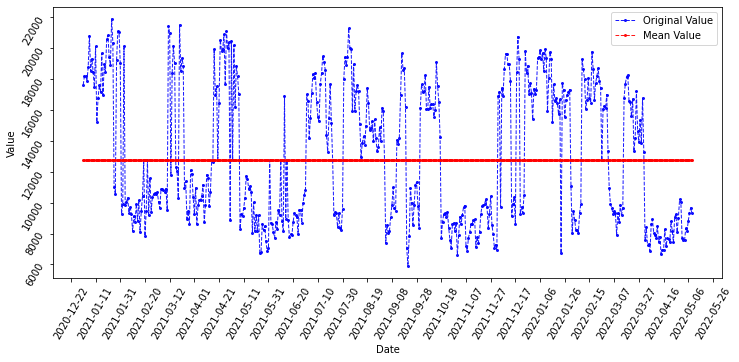

In [8]:
#查看数据大致分布
fig = plt.figure()
fig.set_size_inches(12,5)
ax = fig.add_subplot()
ax.plot(df['date'], df['data'],color='blue',label='Original Value',lw=1,alpha=0.9,linestyle='dashed',marker='o',markersize=2)
ax.plot(df['date'], df['mean'],color='red',label='Mean Value',lw=1,alpha=0.9,linestyle='dashed',marker='o',markersize=2)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(labelrotation=60)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend(loc = 'best')
plt.show()

# 通过ARIMA进行时间序列预测

In [9]:
#进行ADF检验，验证序列是否平稳，并输入对应的统计良与p值
ADF_result = adfuller(df['data']) 
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}') 
#结果显示p远小于0.05，因此拒绝原假设(存在单位根，数据不平稳)，数据是平稳的

ADF Statistic: -6.170992390397676
p-value: 6.806085981340992e-08


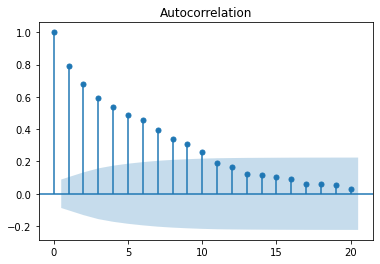

In [10]:
#对时间序列自相关进行分析，用于下一步ARIMA建模提供初步思路
plot_acf(df['data'], lags=20);
#通过自相关图发现，序列存在一定的波动性

In [11]:
#对原始数据进行一阶差分处理
diff_data = np.diff(df['data'], n=1)

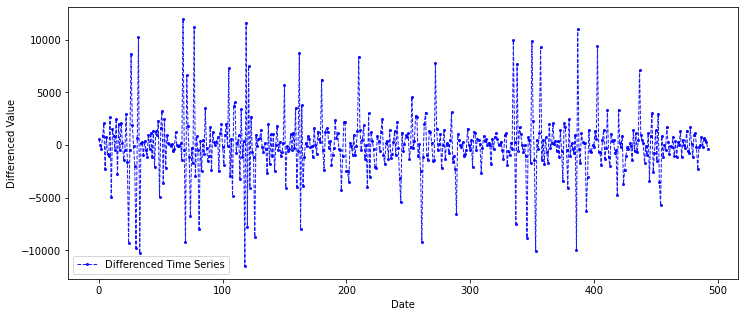

In [12]:
fig = plt.figure()
fig.set_size_inches(12,5)
ax = fig.add_subplot()
ax.plot(diff_data,color='blue',label='Differenced Time Series',lw=1,alpha=0.9,linestyle='dashed',marker='o',markersize=2)
ax.legend(loc = 'best')
ax.set_xlabel('Date')
ax.set_ylabel('Differenced Value')
plt.show()

In [13]:
#对差分后的数据再次进行单位根检验，显示差分后的数据平稳
ADF_result = adfuller(diff_data) 
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -13.322722934055493
p-value: 6.410685663706028e-25


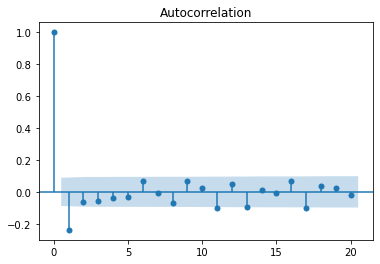

In [14]:
#自相关图显示数据变平稳了
plot_acf(diff_data, lags=20);

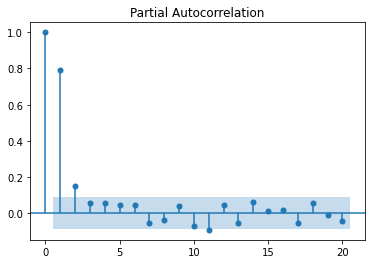

In [15]:
#通过偏自相关系数发现滞后期为2
plot_pacf(df['data'], lags=20);

In [16]:
#生成一些列p，q值，并且遍历所有的情况，寻找最合适的p，q值
ps = range(0, 4, 1) 
qs = range(0, 4, 1) 
order_list = list(product(ps, qs)) 

In [19]:
#定义循环验证函数
def optimize_ARMA(data: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = [] 
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(data, order=(order[0], 0, order[1]),simple_differencing=False).fit(disp=False) 
        except:
            continue
        #提取模型对应的AIC值
        aic = model.aic
        results.append([order, aic]) 
    result_df = pd.DataFrame(results) 
    result_df.columns = ['(p,q)', 'AIC'] 
    #对AIC进行排序，选择AIC最小时候的p，q值
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [20]:
#运行该函数，并且查看结果，结果显示p，q分别为2，2时，AIC最小
pq_df = optimize_ARMA(df['data'], order_list) #A
pq_df

<ipython-input-19-b26811324442>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/16 [00:00<?, ?it/s]

D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:

,"(p,q)",AIC
0,"(2, 2)",9219.509226
1,"(2, 3)",9220.173856
2,"(3, 1)",9222.030653
3,"(3, 3)",9224.549503
4,"(2, 1)",9227.724064
5,"(3, 2)",9229.994669
6,"(1, 3)",9230.252126
7,"(1, 2)",9232.083399
8,"(1, 1)",9237.446491
9,"(3, 0)",9240.999145


In [21]:
#进行ARIMA建模，
model = SARIMAX(df['data'], order=(2,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


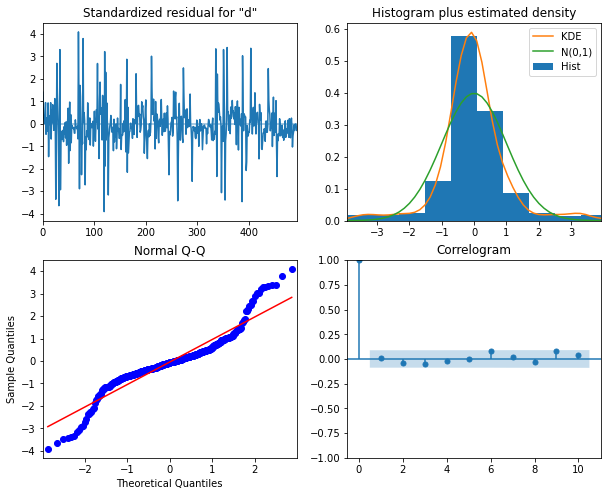

In [72]:
#查看效果
model_fit.plot_diagnostics(figsize=(10, 8));

In [73]:
#对残差进行独立性检验
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1)) #A
print(pvalue)

[0.80576073 0.70131266 0.64551873 0.77491311 0.86603603 0.60872466
 0.69436478 0.74046431 0.58452282 0.58099613]


D:\Python\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [147]:
#分别用均值，历史值加权，ARIMA进行预测
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,2,2)) #A
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [149]:
#对原始数据建模或者对差分后的数据进行建模预测，预测长度为30天
data_diff=df.data
#data_diff = np.diff(df.data, n=1)
df_diff = pd.DataFrame({'data_diff': data_diff})  
df_diff=df_diff.sort_index()
train = df_diff[:-30]
test = df_diff[-30:] #A
print(len(train))
print(len(test))

464
30


In [150]:
#运行函数，并且保存预测结果
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')
pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARMA'] = pred_ARMA
pred_df.head()

D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Python\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarni

,data_diff,pred_mean,pred_last_value,pred_ARMA
464,8482.0,13303.997618,7722.0,7811.857722
465,7469.0,13303.997618,7722.0,7801.395576
466,7807.0,13281.128529,7469.0,7690.456542
467,6677.0,13281.128529,7469.0,7670.779955
468,6963.0,13255.320288,6677.0,6906.483061


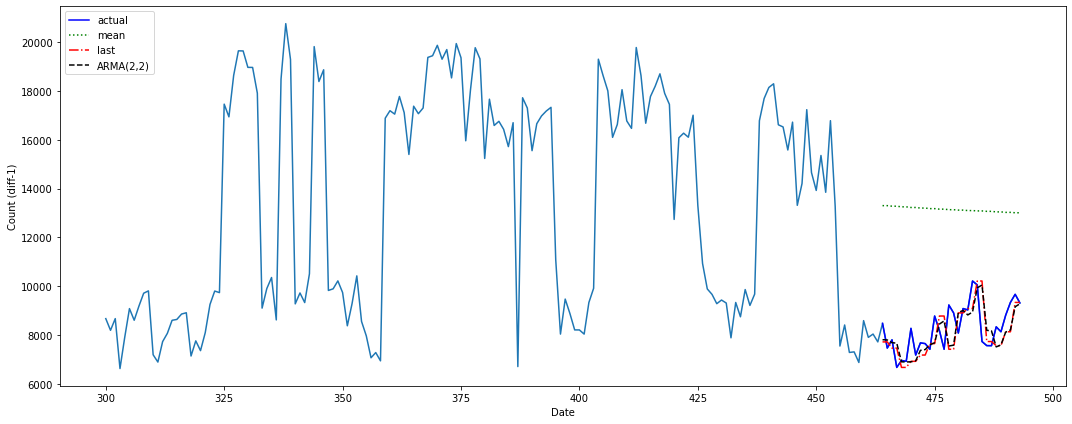

In [151]:
#查看预测效果
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
ax.plot(df_diff.data_diff[300:])
ax.plot(pred_df.data_diff, 'b-', label='actual')
ax.plot(pred_df.pred_mean, 'g:', label='mean')
ax.plot(pred_df.pred_last_value, 'r-.', label='last')
ax.plot(pred_df.pred_ARMA, 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('Date')
ax.set_ylabel('Count (diff-1)')
plt.tight_layout()

In [152]:
#定义MAPE函数
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [153]:
#计算不同预测方法对应的mape
mape(pred_df.data_diff,pred_df.pred_mean)

0.6108833358840574

In [154]:
mape(pred_df.data_diff,pred_df.pred_last_value)

0.083035485965449

In [155]:
mape(pred_df.data_diff,pred_df.pred_ARMA)

0.07972140868793004

# 通过时间序列分解进行时间序列预测

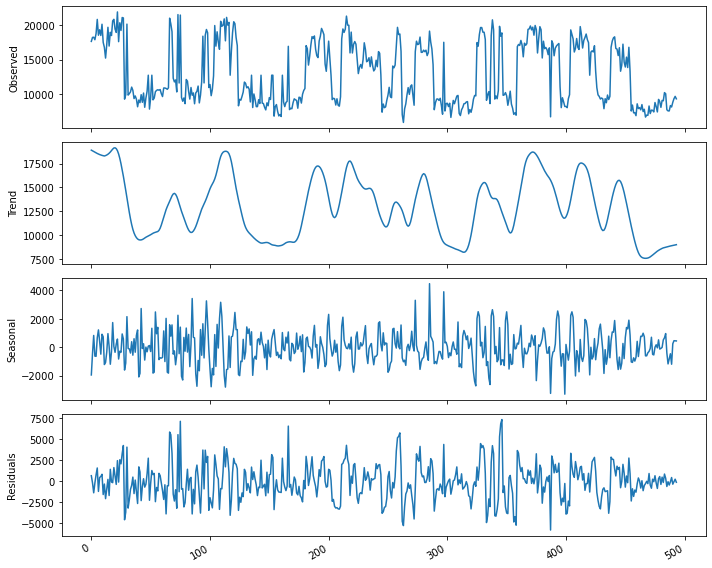

In [165]:
#将原始时间序列分解为长期去世，周期成分，以及残差，这里周期成分设置为12
decomposition = STL(df_diff.data_diff, period=12).fit() #A
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True,figsize=(10,8))
ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
fig.autofmt_xdate()
plt.tight_layout()

In [185]:
#设置季节性ARIMA对应的参数，并且进行网格搜索，确定最优值
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)
d = 1
D = 1
s = 12
ARIMA_order_list = list(product(ps, qs, Ps, Qs)) #

In [186]:
#定义寻优参数函数
def optimize_SARIMA(data: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    results = []
    for order in tqdm_notebook(order_list): 
        try:
            model = SARIMAX(data,order=(order[0], d, order[1]),seasonal_order=(order[2], D, order[3], s),simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    #AIC越小，参数越好
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [187]:
#运行函数，并且查看结果
ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s) 
ARIMA_result_df 
#结果显示最优参数为(1, 1, 1, 2)

<ipython-input-186-80fa6495dbd0>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization

D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization

D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization

D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization

,"(p,q,P,Q)",AIC
0,"(1, 1, 1, 2)",12.000000
1,"(3, 2, 2, 1)",18.000000
2,"(2, 1, 0, 1)",8489.789550
3,"(1, 2, 0, 1)",8490.640241
4,"(2, 1, 0, 2)",8491.488908
...,...,...
251,"(1, 0, 0, 0)",8798.694727
252,"(3, 0, 0, 0)",8799.163332
253,"(0, 2, 0, 0)",8799.292599
254,"(2, 0, 0, 0)",8800.505173


D:\Python\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


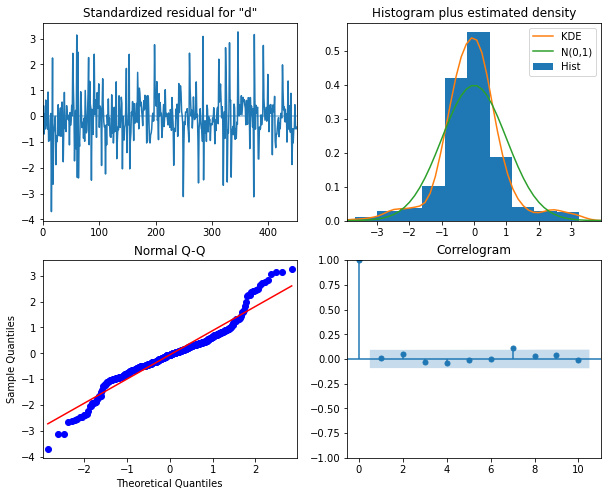

In [189]:
#利用上述参数进行建模，并且对结果进行诊断
SARIMA_model = SARIMAX(train, order=(1,1,2), seasonal_order=(1,1,2,12),simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [190]:
#对残差进行独立性验证
residuals = SARIMA_model_fit.resid
lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(pvalue)

[0.40137524 0.34293949 0.53428191 0.6716947  0.79467809 0.87047696
 0.49045326 0.54151426 0.55812989 0.61337541]


D:\Python\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [191]:
#进行30天的预测
SARIMA_pred = SARIMA_model_fit.get_prediction(462, 493).predicted_mean #A
pred_df['SARIMA_pred'] = SARIMA_pred

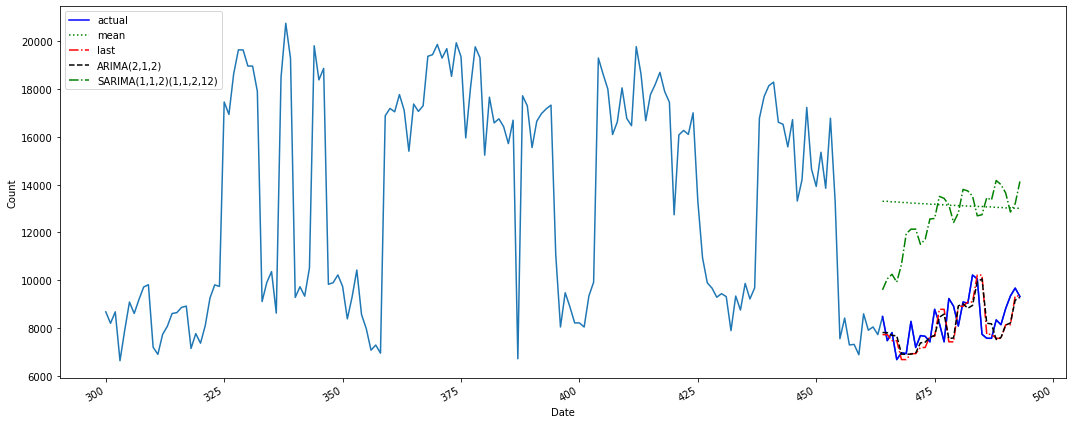

In [194]:
#查看预测效果
fig, ax = plt.subplots()
fig.set_size_inches(15,6)
ax.plot(df_diff.data_diff[300:])
ax.plot(pred_df.data_diff, 'b-', label='actual')
ax.plot(pred_df.pred_mean, 'g:', label='mean')
ax.plot(pred_df.pred_last_value, 'r-.', label='last')
ax.plot(pred_df.pred_ARMA, 'k--', label='ARIMA(2,1,2)')
ax.plot(pred_df.SARIMA_pred, 'g-.', label='SARIMA(1,1,2)(1,1,2,12)')
ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

# 利用机器学习模型进行时间序列预测

In [198]:
#重新读取数据，设置日期列为index
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
dat1=pd.read_excel('D:/data/data.xlsx',index_col=0,parse_dates=['date'],date_parser=dateparse)

In [199]:
dat1.head()

,data
date,
2021-01-01,17638
2021-01-02,18216
2021-01-03,18238
2021-01-04,17879
2021-01-05,18770


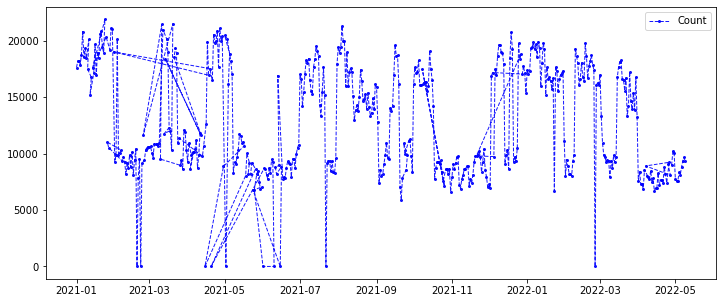

In [256]:
#该图表示，需要对数据根据index进行排序
fig = plt.figure()
fig.set_size_inches(12,5)
ax = fig.add_subplot()
ax.plot(dat1['data'],color='blue',label='Count',lw=1,alpha=0.9,linestyle='dashed',marker='o',markersize=2)
ax.legend(loc = 'best')
plt.show()

In [257]:
#进行排序
df1=dat1.sort_index()

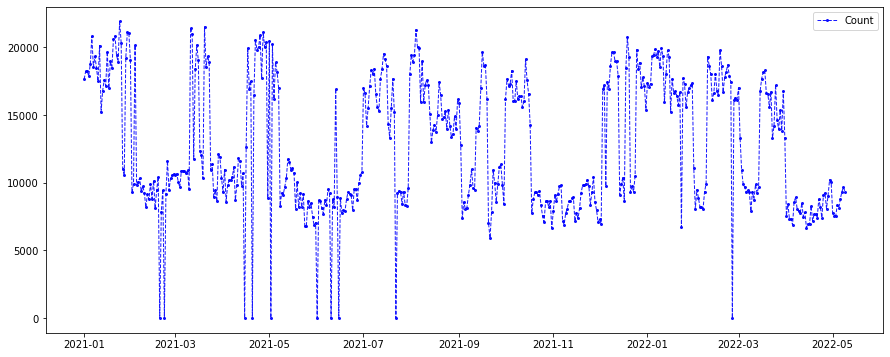

In [203]:
#再次查看
fig = plt.figure()
fig.set_size_inches(15,6)
ax = fig.add_subplot()
ax.plot(df1['data'],color='blue',label='Count',lw=1,alpha=0.9,linestyle='dashed',marker='o',markersize=2)
ax.legend(loc = 'best')
plt.show()

In [205]:
#对0值进行平均值填充
mean1 = np.mean(df1['data'])  
df1['data'].replace(to_replace=0, value = mean1, inplace=True)

In [206]:
#进行特征工程加工
df1['year'] = [x.year for x in df1.index]
df1['month'] = [x.month for x in df1.index]
df1['dayofweek']=[x.dayofweek for x in df1.index]
df1['week'] = [x.week for x in df1.index]

In [218]:
#查看数据
df1.head()

,data,month,year,week,dayofweek
date,,,,,
2021-01-01,17638.0,1,2021,53,4
2021-01-02,18216.0,1,2021,53,5
2021-01-03,18238.0,1,2021,53,6
2021-01-04,17879.0,1,2021,1,0
2021-01-05,18770.0,1,2021,1,1


In [219]:
#再次生成变量，方便进行30天的预测
df1['dff31'] = df1['data'].shift(31)
df1['dff32'] = df1['data'].shift(32)
df1['dff33'] = df1['data'].shift(33)
df1['dff34'] = df1['data'].shift(34)
df1['dff35'] = df1['data'].shift(35)
df1['dff36'] = df1['data'].shift(36)
df1['dff37'] = df1['data'].shift(37)

In [224]:
df1.head(n=20)

,data,month,year,week,dayofweek,dff31,dff32,dff33,dff34,dff35,dff36,dff37
date,,,,,,,,,,,,
2021-02-07,9355.00000,2,2021,5,6,18530.0,20824.0,18770.0,17879.0,18238.0,18216.0,17638.0
2021-02-08,9734.00000,2,2021,6,0,19323.0,18530.0,20824.0,18770.0,17879.0,18238.0,18216.0
2021-02-09,9265.00000,2,2021,6,1,18496.0,19323.0,18530.0,20824.0,18770.0,17879.0,18238.0
2021-02-10,8167.00000,2,2021,6,2,17497.0,18496.0,19323.0,18530.0,20824.0,18770.0,17879.0
2021-02-11,9140.00000,2,2021,6,3,20122.0,17497.0,18496.0,19323.0,18530.0,20824.0,18770.0
2021-02-12,8759.00000,2,2021,6,4,15223.0,20122.0,17497.0,18496.0,19323.0,18530.0,20824.0
2021-02-13,9919.00000,2,2021,6,5,16764.0,15223.0,20122.0,17497.0,18496.0,19323.0,18530.0
2021-02-14,8814.00000,2,2021,6,6,17599.0,16764.0,15223.0,20122.0,17497.0,18496.0,19323.0
2021-02-15,10156.00000,2,2021,7,0,17166.0,17599.0,16764.0,15223.0,20122.0,17497.0,18496.0


In [223]:
#去除含有缺失值的行
df1 = df1.dropna()
df1.head()

,data,month,year,week,dayofweek,dff31,dff32,dff33,dff34,dff35,dff36,dff37
date,,,,,,,,,,,,
2021-02-07,9355.0,2,2021,5,6,18530.0,20824.0,18770.0,17879.0,18238.0,18216.0,17638.0
2021-02-08,9734.0,2,2021,6,0,19323.0,18530.0,20824.0,18770.0,17879.0,18238.0,18216.0
2021-02-09,9265.0,2,2021,6,1,18496.0,19323.0,18530.0,20824.0,18770.0,17879.0,18238.0
2021-02-10,8167.0,2,2021,6,2,17497.0,18496.0,19323.0,18530.0,20824.0,18770.0,17879.0
2021-02-11,9140.0,2,2021,6,3,20122.0,17497.0,18496.0,19323.0,18530.0,20824.0,18770.0


In [228]:
#提取变量，x与y并且进行训练集与验证集的划分，按照80%训练，20%验证
X = df1[['year', 'month', 'week','dayofweek','dff31', 'dff32', 'dff33', 'dff34','dff35','dff36','dff37']]
y = df1['data']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
random_state=12345,shuffle=False)

In [ ]:
# 利用线性回归进行拟合
my_lm = LinearRegression()
my_lm.fit(X = X_train, y = y_train)
train_fcst = my_lm.predict(X_train)
test_fcst = my_lm.predict(X_test)

0.10751094616642198 -1.2981811666458225


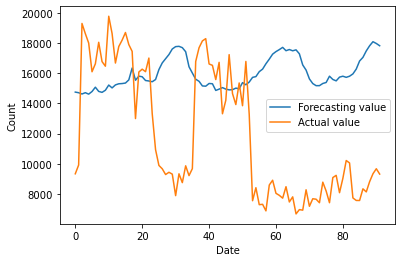

In [232]:
#查看效果
train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)
print(train_r2, test_r2)
plt.plot(list(test_fcst),label="Forecasting value")
plt.plot(list(y_test),label="Actual value")
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(loc="best")
plt.show()

In [234]:
#利用GBDT进行预测
my_xgb = XGBRegressor()
my_xgb.fit(X_train, y_train)
xgb_fcst = my_xgb.predict(X_test)
from sklearn.metrics import r2_score
print(r2_score(list(y_test), list(xgb_fcst)))

-1.3276195898616834


In [236]:
#利用lightGBM进行预测
my_lgbm = LGBMRegressor()
my_lgbm.fit(X_train, y_train)
lgbm_fcst = my_lgbm.predict(X_test)
print(r2_score(list(y_test), list(lgbm_fcst)))

-1.7239831998571158


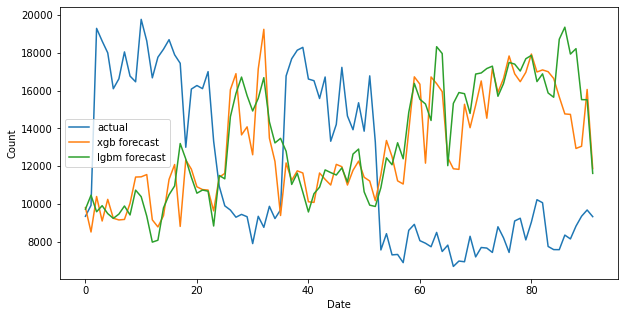

In [238]:
#查看效果
plt.figure(figsize=(10,5))
plt.plot(list(y_test))
plt.plot(list(xgb_fcst))
plt.plot(list(lgbm_fcst))
plt.legend(['actual', 'xgb forecast', 'lgbm forecast'])
plt.ylabel('Count')
plt.xlabel('Date')
plt.show()

# 从图中可以看出机器学习预测效果不是很理想